<a href="https://colab.research.google.com/github/simonefmr/teste/blob/main/ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www3.bcb.gov.br/ranking/historico.do

# **Pós Graduação Ciência de Dados - PUC Rio**
# **MVP Sprint I: Análise de Dados e Boas Práticas**
## Aluna: Simone de Fátima Marques Ramos

## **1. Introdução**

O  Ranking Bacen é formado a partir das reclamações do público registradas nos canais de atendimento do Banco Central (BC): internet, correspondência, presencialmente ou telefone (145). As demandas são analisadas de forma amostral pelo BC.

Participam do Ranking: bancos (comerciais, múltiplos, cooperativos, de investimentos), sociedades de crédito, financiamento e investimento (SCFI), instituições de pagamento e administradoras de consórcio.

São divulgados três arquivos, no formato CSV, com os seguintes detalhamentos:

I- Bancos e financeiras - Reclamações e quantidades de clientes por instituição financeira:
Apresenta as quantidades de reclamações e clientes, por instituição financeira, referentes ao mês
selecionado.

II- Bancos e financeiras - Irregularidades por instituição financeira:
Apresenta as quantidades de reclamações, por irregularidade e instituição financeira, referentes ao
mês selecionado.

III- Bancos e financeiras - Tabela de irregularidades:
Apresenta a tabela de irregularidades referente ao mês selecionado.

Neste projeto, irei abordar apenas os dados das Irregularidades por instituição financeira (II).

### **1.1. Problema de aprendizado supervisionado ou não supervisionado e Hipóteses sobre o problema**

Fazem parte do ranking as reclamações que foram analisadas e encerradas como:

Reclamações reguladas procedentes: casos em que houve sinal de descumprimento de lei ou norma pela instituição financeira no período indicado.
Reclamações reguladas – outras: casos em que não houve sinal de descumprimento de lei ou norma pela instituição financeira no período indicado (inclui as reclamações encerradas como improcedentes e não conclusivas).
Reclamações não reguladas: casos que não são tratados por lei ou norma expedida pelo Banco Central e não são sujeitos a sua supervisão.
Total de reclamações: total de reclamações reguladas procedentes, reclamações reguladas – outras e reclamações não reguladas.

Neste projeto analizarei apenas o **primeiro trimestre de 2023**. Sem base histórica, trataremos como um problema de **aprendizado não supervisionado**, sendo o objetivo entender as possíveis relações entre os dados apresentados.

### **1.2. Definição do Problema** 


O alto índice de reclamações ou reincidência das mesmas, podem levar o Banco Central a multar as instituições financeiras ou aplicar outras ferramentas de supervisão, como termos de compromisso, acordos de leniência, e medidas coercitivas e acautelatórias.

As instituições são classificadas pela ordem decrescente do índice de reclamações, ou seja, da mais reclamada para a menos reclamada.

As Reclamações reguladas – outras e as Reclamações não reguladas são divulgadas, porém não influenciam na posição das instituições no ranking.

No processo de análise, pode ser identificada mais de uma irregularidade para uma mesma reclamação. Nesse caso, cada irregularidade conta como uma ocorrência para cálculo do Ranking de Reclamações.

Tentar entender as origens das reclamações é essencial para monitoramento do correto funcionamento do sistema financeiro pelo Bacen, assim como pelas instituições financeiras, que buscam atendimento de qualidade e não desejam ter suas atividades limitadas ou restritas por força de sanção.

## **2. Importação de pacotes e bibliotecas**

In [172]:
# Importando bibliotecas e pacotes que serão utilizados na análise

# Importação de Bibliotecas
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch, Polygon
from matplotlib.lines import Line2D
import plotly.express as px
from pandas import set_option
from pandas.plotting import scatter_matrix

from IPython.utils.sysinfo import encoding

# para tratamento de data
import datetime

# para tratamento de missings
import missingno as ms 

# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

## transformações numéricas
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.preprocessing import StandardScaler # para padronização

## transformações categóricas
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [173]:
# Versões das Bibliotecas utilizadas

pd_pd = pd.__version__
np_np = np.__version__
sns_sns = sns.__version__

print('Versões utilizadas na análise:')
print('Pandas = '+pd_pd)
print('Numpy = '+np_np)
print('Seaborn = '+sns_sns)

Versões utilizadas na análise:
Pandas = 1.5.3
Numpy = 1.22.4
Seaborn = 0.12.2


## **3. Carregamento dos dados**

Os dados estão disponíveis no site do Banco Central e são publicados desde 2014. 
O relatório trimestral é divulgado no formato CSV, disponível para download, não sendo possível sua consulta direta no site. 

https://www3.bcb.gov.br/ranking/historico.do


In [174]:
# Definindo a url dos dados

url = 'https://raw.githubusercontent.com/simonefmr/teste/main/ranking_irregularidades.csv'

In [175]:
# Carregando o dataset através da url do github

df = pd.read_csv(url, sep=';', encoding='ISO-8859-1')

### **3.1. Condições ou restrições impostas para selecionar os dados**

Não houve dificuldade de carregamento dos dados. Foi preciso ajustar o separador e o encoding para correta leitura do dataset.

### **3.2. Definição dos atributos**

In [176]:
# labels dos atributos do dataset

df.columns

Index(['Ano', 'Trimestre', 'Categoria', 'Tipo', 'CNPJ IF',
       'Instituição financeira', 'Irregularidade',
       'Quantidade de reclamações reguladas procedentes',
       'Quantidade de reclamações reguladas - outras',
       'Quantidade de reclamações não reguladas',
       'Quantidade total de reclamações', 'Unnamed: 11'],
      dtype='object')

**Definindo o que cada atributo representa**

**Ano:** Ano de referência.

**Trimestre:** Trimestre de referência

**Categoria Listagem do ranking:** Mais de dois milhões de clientes ou Menos de dois milhões de clientes.

**Tipo:** Tipo de instituição: Bancos e financeiras ou
Conglomerados.

**CNPJ IF:** CNPJ da instituição financeira (para bancos e financeiras). *Para conglomerados, esse campo não é preenchido.*

**Instituição financeira:** Nome da instituição financeira ou do conglomerado.

**Irregularidade:** Nome da irregularidade.

**Quantidade de reclamações reguladas procedentes:** Quantidade de reclamações reguladas procedentes,
associadas à irregularidade, encerradas no mês de
referência.

**Quantidade de reclamações reguladas - outras:** Quantidade de reclamações reguladas – outras, associadas à irregularidade, encerradas no mês de referência (Não procedentes).

**Quantidade de reclamações não reguladas:** Quantidade de reclamações não reguladas, associadas à irregularidade, encerradas no mês de referência (Irreguladas são reclamações que não tem base regulamentada ou que sua regulamentação não é de competência do Banco Central.

**Quantidade total de reclamações:** Quantidade total de reclamações, associadas à irregularidade, encerradas no mês de referência.

## **4. Análise de Dados**

### **4.1. Limpeza preliminar dos dados**

In [177]:
# Eliminando a coluna "Unnamed" que não possui dados

df.drop(columns=['Unnamed: 11'], inplace=True)

In [178]:
# Busco informações sobre contagem de não nulos e tipo de cada atributo

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3515 entries, 0 to 3514
Data columns (total 11 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   Ano                                              3515 non-null   int64 
 1   Trimestre                                        3515 non-null   object
 2   Categoria                                        3515 non-null   object
 3   Tipo                                             3515 non-null   object
 4   CNPJ IF                                          3515 non-null   object
 5   Instituição financeira                           3515 non-null   object
 6   Irregularidade                                   3515 non-null   object
 7   Quantidade de reclamações reguladas procedentes  3515 non-null   int64 
 8   Quantidade de reclamações reguladas - outras     3515 non-null   int64 
 9   Quantidade de reclamações não reguladas  

In [179]:
# Vamos excluir as colunas "Tipo" e "CNPJ IF" pois não apresentam dados
# relevantes para a análise

df.drop(columns=['Tipo', 'CNPJ IF'], inplace=True)

In [180]:
# Classificando a coluna "Ano" como data

df['Ano'] = pd.to_datetime(df['Ano'], format='%Y')
df.dtypes

Ano                                                datetime64[ns]
Trimestre                                                  object
Categoria                                                  object
Instituição financeira                                     object
Irregularidade                                             object
Quantidade de reclamações reguladas procedentes             int64
Quantidade de reclamações reguladas - outras                int64
Quantidade de reclamações não reguladas                     int64
Quantidade total de reclamações                             int64
dtype: object

In [181]:
# Exibindo as primeiras linhas verifico que o dataset foi carregado corretamente

df.head()

,Ano,Trimestre,Categoria,Instituição financeira,Irregularidade,Quantidade de reclamações reguladas procedentes,Quantidade de reclamações reguladas - outras,Quantidade de reclamações não reguladas,Quantidade total de reclamações
0,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",ABC-BRASIL (conglomerado),Cobrança irregular de tarifa relacionada a con...,0,1,0,1
1,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",ABC-BRASIL (conglomerado),"Débito em conta não autorizado pelo cliente, o...",0,1,0,1
2,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",ABC-BRASIL (conglomerado),Insatisfação com a resposta recebida da instit...,0,2,0,2
3,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",ABC-BRASIL (conglomerado),Insatisfação com o atendimento prestado pelo S...,0,0,1,1
4,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",ABC-BRASIL (conglomerado),Irregularidades relacionadas ao acompanhamento...,1,0,0,1


In [182]:
# Exibindo as últimas linhas

df.tail()

,Ano,Trimestre,Categoria,Instituição financeira,Irregularidade,Quantidade de reclamações reguladas procedentes,Quantidade de reclamações reguladas - outras,Quantidade de reclamações não reguladas,Quantidade total de reclamações
3510,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",YAMAHA MOTOR (conglomerado),Irregularidades relacionadas ao fornecimento d...,0,1,0,1
3511,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",YAMAHA MOTOR (conglomerado),Irregularidades relacionadas ao fornecimento d...,0,2,0,2
3512,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",YAMAHA MOTOR (conglomerado),"Irregularidades relativas a integridade, confi...",1,2,0,3
3513,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",YAMAHA MOTOR (conglomerado),Reclamações relacionadas a assuntos diversos,0,0,2,2
3514,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",YAMAHA MOTOR (conglomerado),Renegociação de dívida (exceto cartão de crédito),0,0,1,1


### **4.2. Análise Descritiva**

In [183]:
# Verificando o formato do dataset

df.shape

(3515, 9)

In [184]:
# Resumo estatístico dos dados completos
df.describe()

,Quantidade de reclamações reguladas procedentes,Quantidade de reclamações reguladas - outras,Quantidade de reclamações não reguladas,Quantidade total de reclamações
count,3515.000000,3515.000000,3515.000000,3515.000000
mean,5.427596,8.357041,3.493883,17.278521
std,21.396468,28.102944,19.324201,47.558424
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,0.000000,3.000000
75%,2.000000,4.000000,1.000000,10.000000
max,395.000000,439.000000,401.000000,810.000000


De um total de 3.515 reclamações apuradas, a média por instituição foi de 17,27, sendo o maior número de 810 para uma mesma instituição.
A média de reclamações procedentes foi de 5,42 por instituição e o maior valor observado foi de 395 para uma mesma instituição.

In [185]:
df['Categoria'].value_counts()

Demais Bancos, Financeiras e Instituições de Pagamento      2198
Top 15 - Bancos, Financeiras e Instituições de Pagamento    1317
Name: Categoria, dtype: int64

In [186]:
# Resumo estatístico das Top 15 Insitituições financeiras, de pagamento ou bancos

df[df['Categoria']=='Top 15 - Bancos, Financeiras e Instituições de Pagamento'].describe()

,Quantidade de reclamações reguladas procedentes,Quantidade de reclamações reguladas - outras,Quantidade de reclamações não reguladas,Quantidade total de reclamações
count,1317.000000,1317.000000,1317.000000,1317.000000
mean,10.294609,17.311314,7.675778,35.281701
std,29.942342,42.570238,30.840512,69.800075
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,2.000000
50%,1.000000,2.000000,0.000000,8.000000
75%,7.000000,13.000000,1.000000,33.000000
max,395.000000,439.000000,401.000000,810.000000


In [187]:
# Resumo estatístico das demais instituições

df[df['Categoria']=='Demais Bancos, Financeiras e Instituições de Pagamento'].describe()

,Quantidade de reclamações reguladas procedentes,Quantidade de reclamações reguladas - outras,Quantidade de reclamações não reguladas,Quantidade total de reclamações
count,2198.000000,2198.000000,2198.000000,2198.000000
mean,2.511374,2.991811,0.988171,6.491356
std,13.134215,10.041241,3.283432,19.712722
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,0.000000,2.000000
75%,1.000000,2.000000,1.000000,5.000000
max,296.000000,256.000000,54.000000,465.000000


In [188]:
# Realizando algumas separações de dataset para melhor visualização e análises

df_categoria_qtd_total = df.groupby(by=['Categoria'], as_index=False)['Quantidade total de reclamações'].sum()
print(df_categoria_qtd_total)

df_categoria_qtd_procedente = df.groupby(by=['Categoria'], as_index=False)['Quantidade de reclamações reguladas procedentes'].sum()
print(df_categoria_qtd_procedente)

                                           Categoria  \
0  Demais Bancos, Financeiras e Instituições de P...   
1  Top 15 - Bancos, Financeiras e Instituições de...   

   Quantidade total de reclamações  
0                            14268  
1                            46466  
                                           Categoria  \
0  Demais Bancos, Financeiras e Instituições de P...   
1  Top 15 - Bancos, Financeiras e Instituições de...   

   Quantidade de reclamações reguladas procedentes  
0                                             5520  
1                                            13558  


**Avaliação Inicial**

No 1ºT/2023, o total de clientes ativos em todas as instituições foi de 356.177.516. Os bancos classificados como "Top 15" possuem 266.027.240 clientes ativos - 74,68% (clientes podem manter contas e/ou operações em diversas instituições).  

De 60734 reclamações realizadas, 19078 foram consideradas procedentes (31,41%). Destas, 71,06% foram direcionadas às 15 maiores instituições financeiras (Top 15), número condizente com o percentual de clientes de sua base.

### **4.3. Tratamento de Missings**

In [189]:
# Contagem de nulos

df.isnull().sum()

Ano                                                0
Trimestre                                          0
Categoria                                          0
Instituição financeira                             0
Irregularidade                                     0
Quantidade de reclamações reguladas procedentes    0
Quantidade de reclamações reguladas - outras       0
Quantidade de reclamações não reguladas            0
Quantidade total de reclamações                    0
dtype: int64

<Axes: >

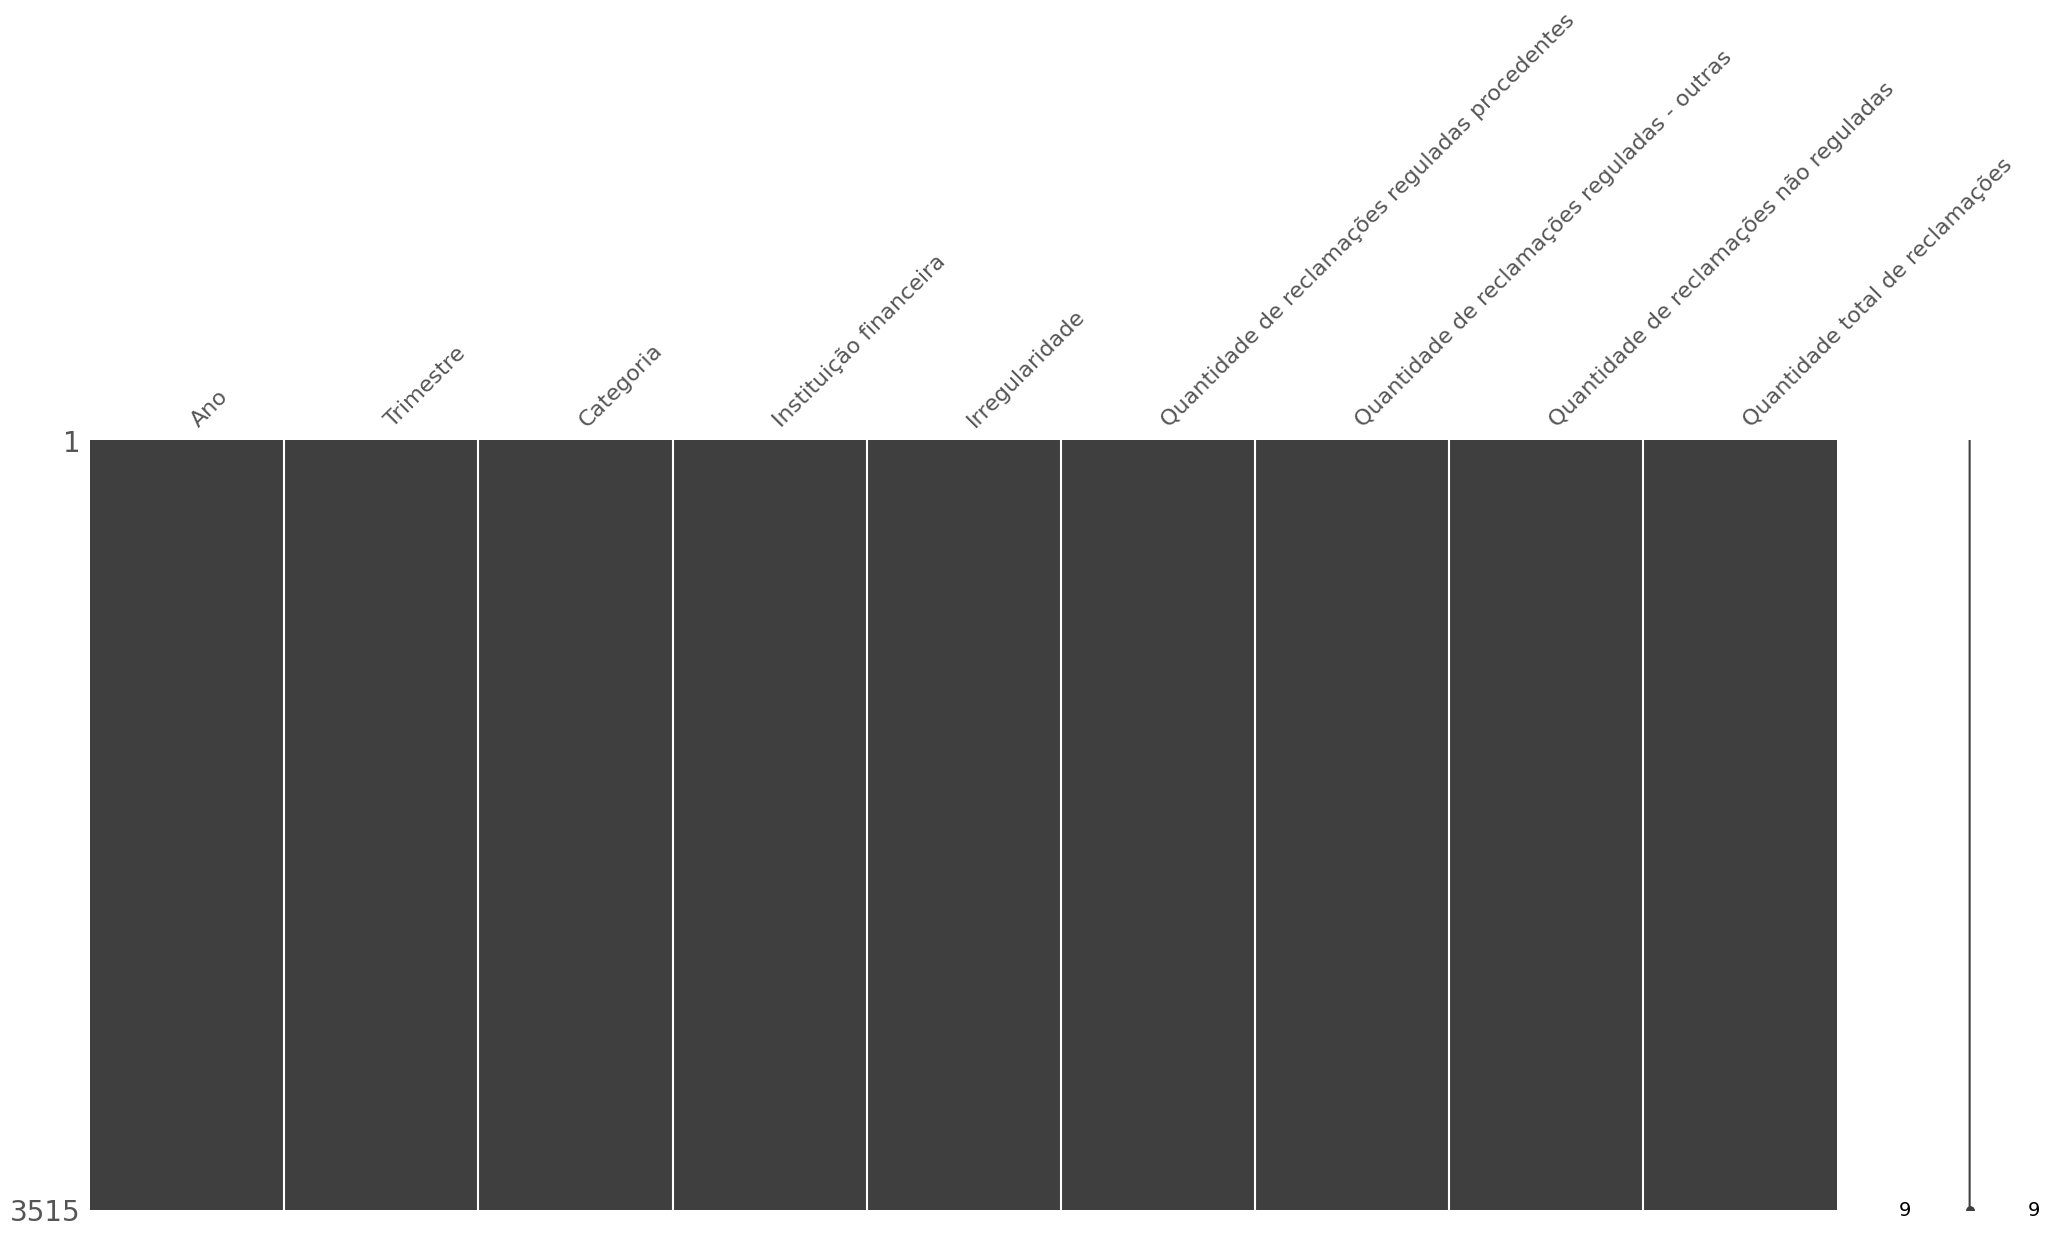

In [190]:
# Exibindo visualização matricial que evidencia a ausência de nulidade do dataset

ms.matrix(df)

Neste caso não será preciso fazer ajustes de faltantes (exclusão ou substituição) pois o dataset está totalmente preenchido.

## **5. Visualizações**

In [191]:
# Define paleta de cores

cores = ['#1A3B5C', '#035B73', '#405B7E', '#CFAF96', '#98796B', '#DC7E3C']

# exibe o mapa de cores
display(cores)

# define uma cor default
corDefault = cores[1]

# Carrega uma folha de estilos (opcional - questões estéticas)
plt.style.use("ggplot")

# Modifica mais alguns parâmetros gráficos (opcional - questões estéticas)
plt.rc("axes", facecolor="#fafafa", grid = True)
plt.rc("grid", color = "#f0f0f0")
plt.rc("axes", edgecolor="#cccccc", lw=0.1)

# plt.rcdefaults() # Restaura a configuração default

['#1A3B5C', '#035B73', '#405B7E', '#CFAF96', '#98796B', '#DC7E3C']

### **5.1. Cria gráfico de barras simples**

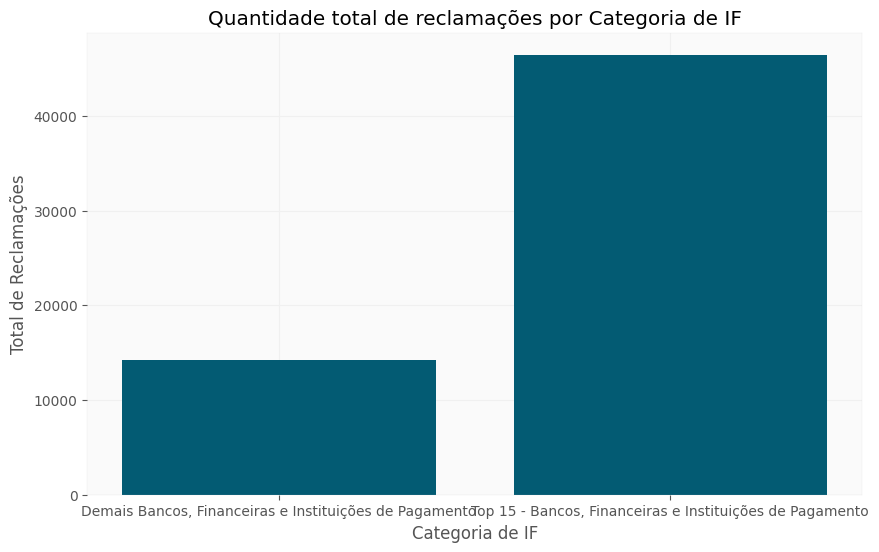

In [200]:
# 1: Plota as barras do total de reclamações 

# Função pyplot.bar()

# Prepara a figura (fig) e a área do gráfico (ax)
fig, ax = plt.subplots(figsize = (10, 6))

# Define o título
plt.title('Quantidade total de reclamações por Categoria de IF')

# Define os rótulos dos eixos
plt.xlabel('Categoria de IF')
plt.ylabel('Total de Reclamações')

# Plota o gráfico de barras
ax.bar(x = df_categoria_qtd_total['Categoria'], height = df_categoria_qtd_total['Quantidade total de reclamações'], color = corDefault)

# Exibe o gráfico
plt.show()

## **6. Pré-processamento**

### **6.1. Divisão do dataset em conjunto de treino e teste**

### **6.2. Normalização e padronização**

### **6.3. Transformações categóricas**

## Conclusão**